In [12]:
import torch
import pytorch_lightning as pl

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

from hydra.experimental import initialize, compose

from bliss import sleep
from bliss.datasets import simulated, sdss

import numpy as np
import time 

torch.manual_seed(184)
np.random.seed(143)

1.7.1


# Get config file

In [4]:
overrides = dict(
    model="sleep_m2",
    dataset="m2",
    training="m2",
    optimizer="m2"
)

overrides = [f"{key}={value}" for key, value in overrides.items()]

In [5]:
with initialize(config_path="../../config"):
    cfg = compose("config", overrides=overrides)

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


# Load dataset and encoder

In [6]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)
sleep_net = sleep.SleepPhase(**cfg.model.kwargs)
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


### Check priors

Text(0.5, 0, 'n-sources per tile')

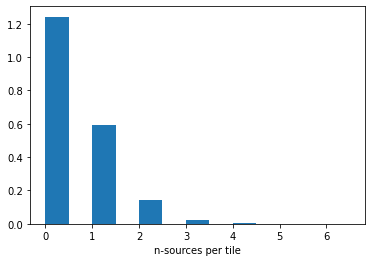

In [7]:
# prior on n-stars

%matplotlib inline

plt.hist(dataset.get_batch()['n_sources'].flatten().cpu().numpy(), 
         bins=np.arange(7, step = 0.5), 
         density = True);

plt.xlabel('n-sources per tile')

Text(0.5, 0, 'log10(fluxes)')

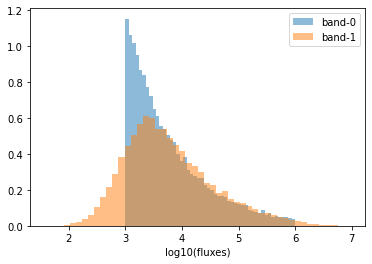

In [8]:
# prior on fluxes

%matplotlib inline

for b in range(2): 
    
    fluxes = dataset.get_batch()['fluxes'][:, :, :, b]
    fluxes = fluxes.flatten()
    fluxes = fluxes[fluxes > 0]


    plt.hist(np.log10(fluxes.cpu().numpy()), 
                     density = True, 
                     alpha = 0.5, 
                     label = 'band-' + str(b), 
                     bins = 50)
    
plt.legend()

plt.xlabel('log10(fluxes)')

Text(0.5, 0, 'color')

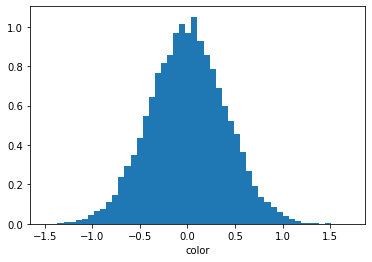

In [9]:
# prior on colors

%matplotlib inline

plt.figure()

fluxes = dataset.get_batch()['fluxes']
colors = (torch.log10(fluxes[:, :, :, 1]) - 
           torch.log10(fluxes[:, :, :, 0])).flatten()
colors = colors[fluxes[:, :, :, 0].flatten() > 0]

bins = plt.hist(colors.cpu().numpy(), 
                 density = True, bins = 50)

plt.xlabel('color')

# Plot a simulated image

In [10]:
batch = dataset.get_batch()

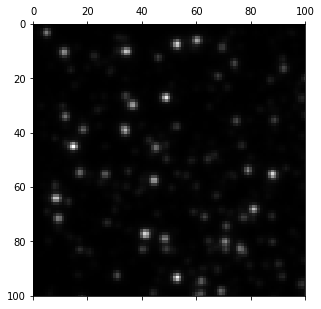

In [11]:
%matplotlib inline

image_indx = 0

image = batch['images'][image_indx, 0].cpu()

f, axarr = plt.subplots(1, 1, figsize=(5, 5))
plotting.plot_image(axarr, image)

### some subimages

In [12]:
slen = dataset.image_decoder.slen
border_padding = dataset.image_decoder.border_padding

In [13]:
from bliss.models.encoder import get_full_params

In [14]:
# get locations on the full image
full_params = get_full_params(dict({'n_sources': batch['n_sources'][0:1], 
                                    'locs': batch['locs'][0:1]}), 
                              slen)

locs_full = full_params['locs']

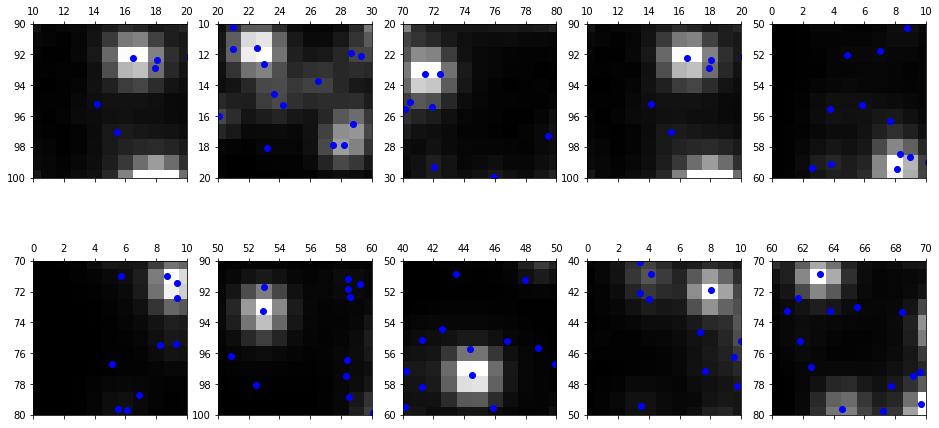

In [15]:
f, axarr = plt.subplots(2, 5, figsize=(16, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(locs_full.squeeze(), slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    
    plotting.plot_image(ax, image, 
               x0, x1, subimage_slen, subimage_slen)


# Train!

In [16]:
t0 = time.time()
trainer.fit(sleep_net, datamodule = dataset)
torch.save(sleep_net.image_encoder.state_dict(), './starnet')

print('TOTAL TIME ELAPSED: {:.3f}secs'.format(time.time() - t0))

# sleep_net.image_encoder.load_state_dict(torch.load('./starnet')); 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 398 K 
1 | image_decoder | ImageDecoder | 12    
-----------------------------------------------
398 K     Trainable params
12        Non-trainable params
398 K     Total params
1.595     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

TOTAL TIME ELAPSED: 3622.097secs


In [18]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

# Results on SDSS data

### Load SDSS data

In [6]:
import os

In [7]:
hubble_data = np.load(os.path.join('../../data/true_hubble_m2.npz'))

In [8]:
sdss_image = torch.from_numpy(hubble_data["sdss_image"]).to(device)
print(sdss_image.shape)

# the true parameters
hubble_locs = torch.from_numpy(hubble_data["true_locs"]).to(device)
hubble_fluxes = torch.from_numpy(hubble_data["true_fluxes"]).to(device)
nelec_per_nmgy = torch.from_numpy(hubble_data["nelec_per_nmgy"]).to(device)

torch.Size([2, 106, 106])


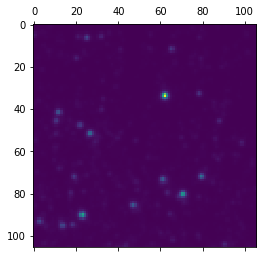

In [13]:
plt.matshow(sdss_image[0].cpu().numpy())

### get map estimates

In [23]:
sleep_net.image_encoder.map_estimate?

In [24]:
map_estimate = sleep_net.image_encoder.map_estimate(sdss_image.unsqueeze(0), 
                                                    dataset.image_decoder.slen)

map_nstars = map_estimate['n_sources'].detach()
map_locs = map_estimate['locs'].detach()
map_log_fluxes = map_estimate['log_fluxes'].detach()

# all galaxies should be off
assert torch.all(map_estimate['galaxy_bool'] == 0.)

In [25]:
print(map_nstars)

tensor([1372.], device='cuda:0')


### Example subimages

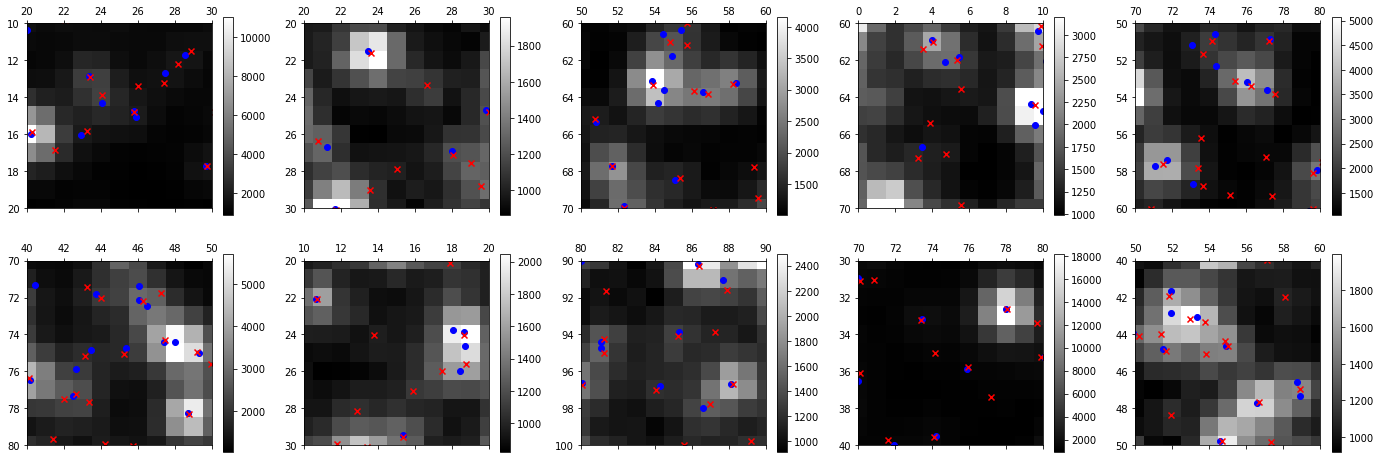

In [26]:
f, axarr = plt.subplots(2, 5, figsize=(24, 8))

subimage_slen = 10
indx_vec = np.arange(0, slen, subimage_slen)

for i in range(10): 
    x0 = np.random.choice(indx_vec)
    x1 = np.random.choice(indx_vec)
    
    ax = axarr[i // 5,  i % 5]
    
    plotting.plot_locations(hubble_locs, slen, border_padding, 
                            ax, marker = 'o', color = 'b')
    plotting.plot_locations(map_locs.squeeze(), slen, border_padding, 
                            ax, marker = 'x', color = 'red')
    
    im = plotting.plot_image(ax, sdss_image[0], 
               x0, x1, subimage_slen, subimage_slen)
    
    f.colorbar(im, ax = ax)

### Summary statistics

In [27]:
from bliss.metrics import get_tpr_ppv

In [28]:
hubble_mags = 22.5 - 2.5 * torch.log10(hubble_fluxes[:, 0:1] / nelec_per_nmgy)
map_mags = 22.5 - 2.5 * torch.log10(map_log_fluxes.exp()[0, :, 0:1] / nelec_per_nmgy)


tpr, ppv = get_tpr_ppv(
            hubble_locs * slen,
            hubble_mags,
            map_locs.squeeze() * slen,
            map_mags,
            slack=0.5,
        )

print('True positive rate: {:.3f}'.format(tpr))
print('Positive predictive value: {:.3f}'.format(ppv))
print('F1: {:.3f}'.format(2 * tpr * ppv / (tpr + ppv)))

True positive rate: 0.564
Positive predictive value: 0.471
F1: 0.513


# Get summary statistics as a function of magnitude

In [29]:
def get_tpr_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    # convert to magnitude
    tpr_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_true = (true_mags > mag_bins[i]) & (true_mags < mag_bins[i + 1])
        which_true = which_true.squeeze()
        counts_vec[i] = torch.sum(which_true)

        tpr_vec[i] = get_tpr_ppv(
            true_locs[which_true],
            true_mags[which_true],
            est_locs,
            est_mags,
            slack = 0.5
        )[0]

    return tpr_vec, mag_bins, counts_vec


def get_ppv_vec(
    true_locs, true_mags, est_locs, est_mags, mag_bins
):

    ppv_vec = np.zeros(len(mag_bins) - 1)
    counts_vec = np.zeros(len(mag_bins) - 1)

    for i in range(len(mag_bins) - 1):
        which_est = (est_mags > mag_bins[i]) & (est_mags < mag_bins[i + 1])
        which_est = which_est.squeeze()
        
        counts_vec[i] = torch.sum(which_est)
        
        ppv_vec[i] = get_tpr_ppv(
                    true_locs,
                    true_mags,
                    est_locs[which_est],
                    est_mags[which_est],
                    slack = 0.5
                )[1]
    
    return ppv_vec, mag_bins, counts_vec


In [30]:
# percentiles of the hubble magnitudes.
percentiles = np.linspace(0, 1, 11) * 100
mag_bins = np.percentile(hubble_mags.cpu(), percentiles)
        
# get tpr as function of magnitude
tpr_vec  = \
    get_tpr_vec(hubble_locs * slen,
            hubble_mags,
            map_locs.squeeze() * slen,
            map_mags, 
                mag_bins)[0]

# # get ppv as function of magnitude
ppv_vec  = \
    get_ppv_vec(hubble_locs * slen,
            hubble_mags,
            map_locs.squeeze() * slen,
            map_mags, 
                   mag_bins)[0]

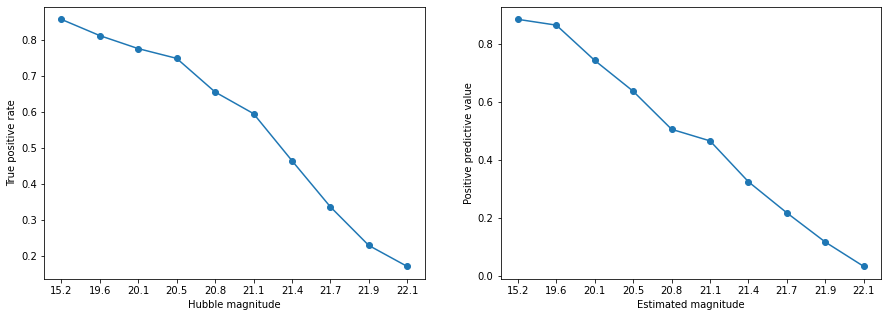

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 5))


# plot summary statistics as function of hubble percentile
percentiles = np.linspace(0, 1, 10 + 1) * 100
axarr[0].plot(percentiles[:-1], tpr_vec, '-o')
axarr[1].plot(percentiles[:-1], ppv_vec, '-o')

# axis labels
axarr[0].set_xlabel('Hubble magnitude')
axarr[1].set_xlabel('Estimated magnitude')
axarr[0].set_ylabel('True positive rate')
axarr[1].set_ylabel('Positive predictive value')

# replace percentiles with actual magnitudes
for i in range(2): 
    axarr[i].set_xticks(percentiles[:-1])
    axarr[i].set_xticklabels(np.round(mag_bins, 1)[:-1])


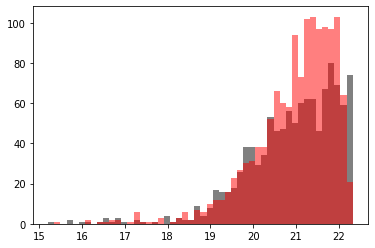

In [32]:
# flux distributions
bins = plt.hist(hubble_mags.cpu().numpy(), color = 'grey', bins = 50);
plt.hist(map_mags.cpu().numpy(), color = 'red', alpha = 0.5, bins = bins[1]);

In [ ]:
# np.savez('../../data/true_hubble_m2', 
#          sdss_image = sdss_image.cpu(), 
#          true_locs = hubble_locs.cpu(), 
#          true_fluxes = hubble_fluxes.cpu(), 
#          nelec_per_nmgy = nelec_per_nmgy)